In [1]:
import h5py
import cv2
import warp_norm
import matplotlib
import sys
sys.path.append("./FaceAlignment")
import face_alignment
from skimage import io
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

fileroot = '/home/hgh/hghData/gaze/eve/valpart/val01/step030_video_Wikimedia-Joy-and-Heron-Animated-CGI-Spot-by-Passion-Pictures/basler.h5'

file = h5py.File(fileroot, 'r')
file.keys()

<KeysViewHDF5 ['camera_matrix', 'camera_transformation', 'face_PoG_tobii', 'face_R', 'face_W', 'face_g_tobii', 'face_h', 'face_o', 'facial_landmarks', 'head_rvec', 'head_tvec', 'inv_camera_transformation', 'left_PoG_tobii', 'left_R', 'left_W', 'left_g_tobii', 'left_h', 'left_o', 'left_p', 'millimeters_per_pixel', 'pixels_per_millimeter', 'right_PoG_tobii', 'right_R', 'right_W', 'right_g_tobii', 'right_h', 'right_o', 'right_p']>

In [2]:
camera_matrix = file['camera_matrix'][:]
print('camera_matrix:')
print(camera_matrix)


camera_transformation = file['camera_transformation'][:]
print('camera_transformation:')
print(camera_transformation)


head_rvec = file['head_rvec']['data']
print('head_rvec:')
print(head_rvec)


head_tvec = file['head_tvec']['data']
print('head_tvec:')
print(head_tvec)


tobii = file['face_PoG_tobii']['data']
print('gaze[0]:')
print(tobii[0])

gaze_o = file['face_o']['data']
print('gaze_o[0]:')
print(gaze_o[0])

gazen = file['face_g_tobii']['data']
print('gazen[0]:')
print(gazen[0])

facial_landmarks = file['facial_landmarks']['data']
print('facial_landmarks:')
print(facial_landmarks)

pixel_scale = file['millimeters_per_pixel'][:]
print(pixel_scale)

camera_matrix:
[[1.7806042e+03 0.0000000e+00 9.5932886e+02]
 [0.0000000e+00 1.7798547e+03 5.7931006e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
camera_transformation:
[[-9.9983627e-01  1.1720656e-02  1.3788454e-02  2.6548169e+02]
 [ 6.6146357e-03  9.4589680e-01 -3.2440028e-01 -4.2144687e+02]
 [-1.6844638e-02 -3.2425594e-01 -9.4581938e-01  1.4901649e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
head_rvec:
<HDF5 dataset "data": shape (3600, 3, 1), type "<f4">
head_tvec:
<HDF5 dataset "data": shape (3600, 3, 1), type "<f4">
gaze[0]:
[955.92834 554.2141 ]
gaze_o[0]:
[ -6.5969653 -66.74155   689.5632   ]
gazen[0]:
[ 0.42263967 -0.01310608]
facial_landmarks:
<HDF5 dataset "data": shape (3600, 68, 2), type "<f4">
[0.28802082 0.28796297]


# 计算标定点和ground truth标定点的偏差

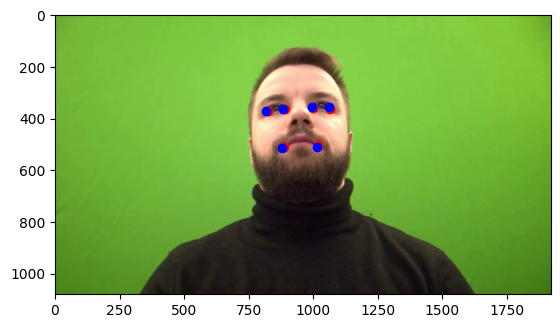

[[ 822.1663   370.     ]
 [ 884.       362.     ]
 [ 996.       351.8337 ]
 [1062.       356.     ]
 [ 876.6112   515.3888 ]
 [1016.       509.38876]]
[[ 825.  370.]
 [ 892.  364.]
 [ 999.  357.]
 [1066.  364.]
 [ 885.  511.]
 [1019.  504.]]


In [3]:
import sys
sys.path.append("./FaceAlignment")
import face_alignment
from skimage import io
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# 预测的2D人脸标定点,使用xgaze方式（红）
# load face model
video_path = fileroot[:-3] + '.mp4'
cap = cv2.VideoCapture(video_path)
idx = 0
face_xgaze = []
while idx != 10:
    ret,frame = cap.read()
    # cv2.imshow('Frames', frame)
    
    fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, flip_input=False)
    preds = fa.get_landmarks(frame)
    landmark_use = [36,39,42,45,48,54]
    lm = preds[0]
    lm = lm[landmark_use, :]
    face_xgaze.append(lm)
    idx += 1
face_xgaze = np.array(face_xgaze)
cap = cv2.VideoCapture(video_path)
ret,frame = cap.read()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.scatter(face_xgaze[0,:,0],face_xgaze[0,:,1],c='r')

# eve提供的参考2D人脸中心(蓝)
landmark_use = [36,39,42,45,48,54]
face_eve = facial_landmarks[0:10,landmark_use, :]
plt.scatter(face_eve[0,:,0],face_eve[0,:,1],c='b')
# 显示第一张图片
plt.show() 

print(face_eve[1])
print(face_xgaze[1])

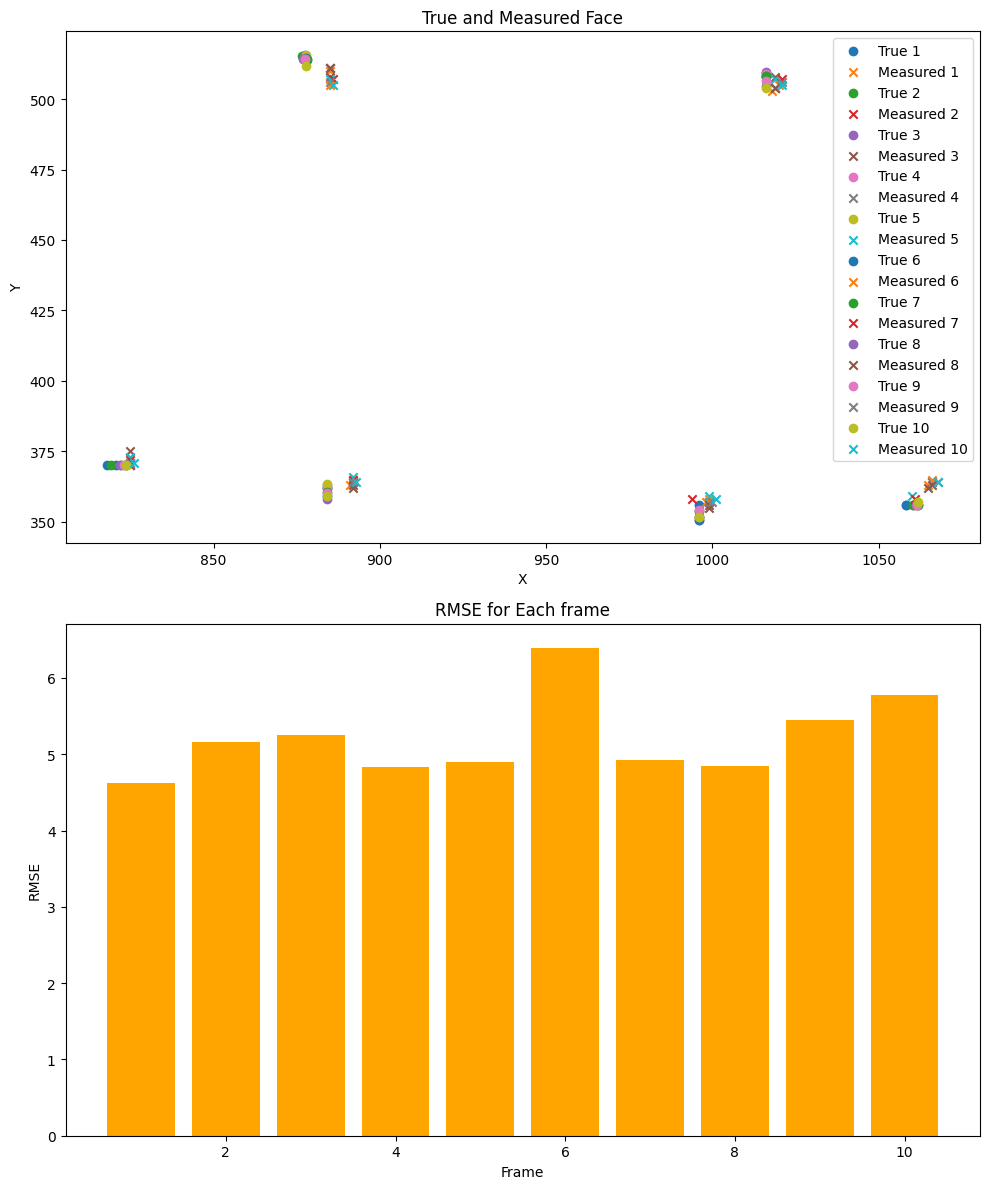

In [21]:
import sys
sys.path.append("./FaceAlignment")
import face_alignment
from skimage import io
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt


# 计算每组数据的均方根误差（RMSE）
rmse_values = [np.sqrt(np.mean((true - measured)**2)) for true, measured in zip(face_eve, face_xgaze)]

# 可视化
plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 1)
for i in range(10):
    plt.scatter(face_eve[i,:, 0], face_eve[i,:, 1], marker='o', label=f'True {i+1}')
    plt.scatter(face_xgaze[i,:, 0], face_xgaze[i,:, 1], marker='x', label=f'Measured {i+1}')

plt.title('True and Measured Face')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.subplot(2, 1, 2)
plt.bar(range(1, 10+1), rmse_values, color='orange')
plt.title('RMSE for Each frame')
plt.xlabel('Frame')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()



# 测算hr，ht的误差

In [22]:
import sys
sys.path.append("./FaceAlignment")
import face_alignment
from skimage import io
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import warp_norm

# 预测的2D人脸标定点,使用xgaze方式（红）
# load face model
video_path = fileroot[:-3] + '.mp4'
cap = cv2.VideoCapture(video_path)
idx = 0
hr_xgaze = []
ht_xgaze = []
while idx != 10:
    ret,frame = cap.read()
    # cv2.imshow('Frames', frame)

    
    # load face model
    face_model_load = np.loadtxt('./modules/face_model.txt')  # Generic face model with 3D facial landmarks
    landmark_use = [20, 23, 26, 29, 15, 19]  # we use eye corners and nose conners
    face_model = face_model_load[landmark_use, :]
    # estimate the head pose,
    ## the complex way to get head pose information, eos library is required,  probably more accurrated
    # landmarks = landmarks.reshape(-1, 2)
    # head_pose_estimator = HeadPoseEstimator()
    # hr, ht, o_l, o_r, _ = head_pose_estimator(image, landmarks, camera_matrix[cam_id])
    ## the easy way to get head pose information, fast and simple
    facePts = face_model.reshape(6, 1, 3)

    # 检测得到的人脸标定点，将其调整为对应3D点的形式
    # landmarks_sub = landmarks[[36, 39, 42, 45, 31, 35], :]
    landmark_sub = face_xgaze
    landmarks_sub = landmarks_sub.astype(float)  # input to solvePnP function must be float type
    landmarks_sub = landmarks_sub.reshape(6, 1, 2)  # input to solvePnP requires such shape
    hr, ht = estimateHeadPose(landmarks_sub, facePts, camera_matrix)

    hr_xgaze.append(hr.reshape((1,3))[0])
    ht_xgaze.append(ht.reshape((1,3))[0])
    idx += 1
hr_xgaze = np.array(hr_xgaze)
ht_xgaze = np.array(ht_xgaze)

hr = head_rvec[0:10]
ht = head_tvec[0:10]


detected one face
detected one face
detected one face
detected one face
detected one face
detected one face
detected one face
detected one face
detected one face
detected one face


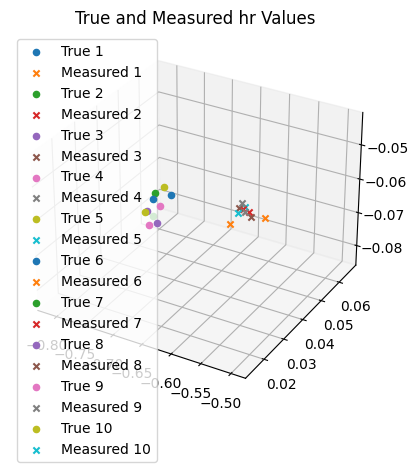

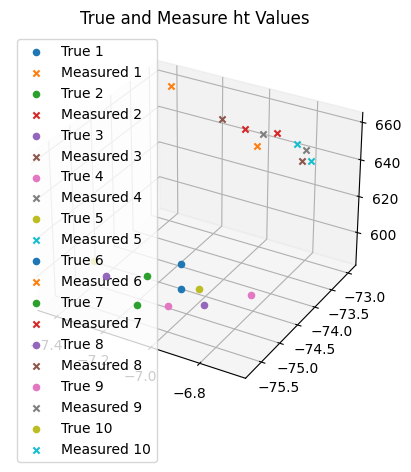

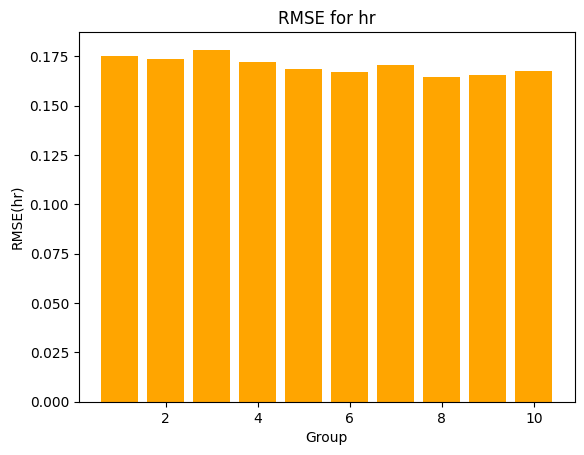

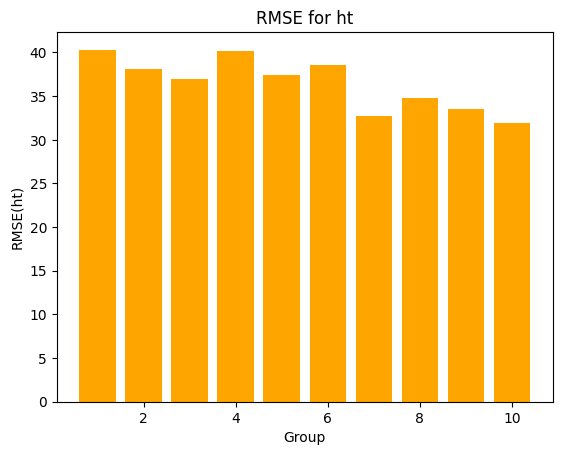

In [23]:
import sys
sys.path.append("./FaceAlignment")
import face_alignment
from skimage import io
import cv2
import numpy as np
import torch
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


hr = hr.reshape((10,3))
ht = ht.reshape((10,3))

# 计算每组数据的均方根误差（RMSE）
rmse_hr = [np.sqrt(np.mean((true - measured)**2)) for true, measured in zip(hr, hr_xgaze)]
rmse_ht = [np.sqrt(np.mean((true - measured)**2)) for true, measured in zip(ht, ht_xgaze)]

# 可视化
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
for i in range(10):
    ax.scatter(hr_xgaze[i, 0], hr_xgaze[i, 1], hr_xgaze[i, 2], marker='o', label=f'True {i+1}')
    ax.scatter(hr[i, 0], hr[i, 1], hr[i, 2], marker='x', label=f'Measured {i+1}')

plt.title('True and Measured hr Values')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
for i in range(10):
    ax.scatter(ht_xgaze[i, 0], ht_xgaze[i, 1], ht_xgaze[i, 2], marker='o', label=f'True {i+1}')
    ax.scatter(ht[i, 0], ht[i, 1], ht[i, 2], marker='x', label=f'Measured {i+1}')

plt.title('True and Measure ht Values')
plt.legend()
plt.show()

plt.bar(range(1, 10+1), rmse_hr, color='orange')
plt.title('RMSE for hr')
plt.xlabel('Group')
plt.ylabel('RMSE(hr)')
plt.show()

plt.bar(range(1, 10+1), rmse_ht, color='orange')
plt.title('RMSE for ht')
plt.xlabel('Group')
plt.ylabel('RMSE(ht)')
plt.show()


In [30]:
print(hr_xgaze.shape, hr.shape)

for htg, htgt in zip(ht_xgaze, ht):
    print(htg/np.linalg.norm(htg,2),htgt/np.linalg.norm(htgt,2), '--wejfioj')


(10, 3) (10, 3)
[-0.01209483 -0.12531303  0.99204353] [-0.01118254 -0.1103596   0.99382883] --wejfioj
[-0.01212012 -0.12572049  0.99199166] [-0.01041241 -0.11120921  0.99374247] --wejfioj
[-0.01214803 -0.12534253  0.99203915] [-0.01065175 -0.11085869  0.9937791 ] --wejfioj
[-0.01154563 -0.12569165  0.99200217] [-0.01046436 -0.11131835  0.99372977] --wejfioj
[-0.01248115 -0.12573731  0.99198506] [-0.01028074 -0.11149988  0.9937113 ] --wejfioj
[-0.01181832 -0.12564827  0.99200446] [-0.01037814 -0.11168053  0.99368995] --wejfioj
[-0.01178034 -0.12584     0.9919806 ] [-0.01065133 -0.11159275  0.9936969 ] --wejfioj
[-0.01146778 -0.12527368  0.99205594] [-0.01014267 -0.11197358  0.9936594 ] --wejfioj
[-0.01160145 -0.12543314  0.99203424] [-0.01019226 -0.11157631  0.9937036 ] --wejfioj
[-0.01145276 -0.12412346  0.99220069] [-0.01010854 -0.11189515  0.9936686 ] --wejfioj


# 使用xgaze方式预测注视向量

In [7]:
from model import gaze_network
from torchvision import transforms

# 模型读取
trans = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),  # this also convert pixel value from [0,255] to [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
model = gaze_network()
model.cuda()
pre_trained_model_path = './ckpt/epoch_24_ckpt.pth.tar'
ckpt = torch.load(pre_trained_model_path)
model.load_state_dict(ckpt['model_state'], strict=True)
model.eval()

# 数据预处理
cap = cv2.VideoCapture(video_path)
pred_norm = []
pred = []
idx = 0
while idx != 10:
    ret,image = cap.read()
    hr, ht = warp_norm.xnorm(image, camera_matrix)
    if(hr.all() == 0 and ht.all() == 0):
        warp_image = np.zeros((224,224,3), dtype=np.byte)
        gcn = np.zeros((3,1))
        R = np.zeros((3,3))
    face_model_load = np.loadtxt('./modules/face_model.txt')  # Generic face model with 3D facial landmarks
    landmark_use = [20, 23, 26, 29, 15, 19]  # we use eye corners and nose conners
    face_model = face_model_load[landmark_use, :]
    warp_image,_,gcn,R = warp_norm.xtrans(image, face_model, hr, ht, camera_matrix, pixel_scale,gc = np.array([100,100,0]))

    # 模型推理
    input_var = warp_image[:, :, [2, 1, 0]]  # from BGR to RGB
    input_var = trans(input_var)
    input_var = torch.autograd.Variable(input_var.float().cuda())
    input_var = input_var.view(1, input_var.size(0), input_var.size(1), input_var.size(2))  # the input must be 4-dimension
    pred_gaze = model(input_var)  # get the output gaze direction, this is 2D output as pitch and raw rotation
    pred_gaze = pred_gaze[0] # here we assume there is only one face inside the image, then the first one is the prediction
    pred_gaze_np = pred_gaze.cpu().data.numpy()  # convert the pytorch tensor to numpy array
    print('Predict normalization gaze vector(pitch yaw):', pred_gaze_np)
    pred_norm.append(pred_gaze_np)
    pred.append(np.dot(np.linalg.inv(R),warp_norm.pitchyaw_to_vector(np.array([pred_gaze_np])).T))
    print('Ground truth gaze vector:', gazen[0])

    idx += 1

detected one face
face_center [[ -5.53693555]
 [-66.06763842]
 [620.53177457]]
Predict normalization gaze vector(pitch yaw): [ 0.45268083 -0.03695702]
Ground truth gaze vector: [ 0.42263967 -0.01310608]
detected one face
face_center [[ -5.78910328]
 [-66.22407272]
 [623.19023994]]
Predict normalization gaze vector(pitch yaw): [ 0.44419876 -0.03523842]
Ground truth gaze vector: [ 0.42263967 -0.01310608]
detected one face
face_center [[ -5.95719688]
 [-66.71675453]
 [628.99271457]]
Predict normalization gaze vector(pitch yaw): [ 0.44039914 -0.02900674]
Ground truth gaze vector: [ 0.42263967 -0.01310608]
detected one face
face_center [[ -5.52741063]
 [-65.96617643]
 [620.15754449]]
Predict normalization gaze vector(pitch yaw): [ 0.4529857  -0.03432234]
Ground truth gaze vector: [ 0.42263967 -0.01310608]
detected one face
face_center [[ -5.85334191]
 [-66.50424024]
 [623.58916245]]
Predict normalization gaze vector(pitch yaw): [ 0.44958496 -0.03220256]
Ground truth gaze vector: [ 0.4226396

[[ 0.45268083 -0.03695702]
 [ 0.44419876 -0.03523842]
 [ 0.44039914 -0.02900674]
 [ 0.4529857  -0.03432234]
 [ 0.44958496 -0.03220256]
 [ 0.4472887  -0.02748967]
 [ 0.443636   -0.03987949]
 [ 0.44395426 -0.03933781]
 [ 0.443316   -0.04062015]
 [ 0.43686056 -0.03645614]]
[[ 0.42263967 -0.01310608]
 [ 0.42299235 -0.01022695]
 [ 0.4212336  -0.01062942]
 [ 0.42253697 -0.01055713]
 [ 0.42371535 -0.01041129]
 [ 0.42354727 -0.01002752]
 [ 0.42378467 -0.01035698]
 [ 0.42515433 -0.00984226]
 [ 0.42459437 -0.00926075]
 [ 0.4247257  -0.00983722]]


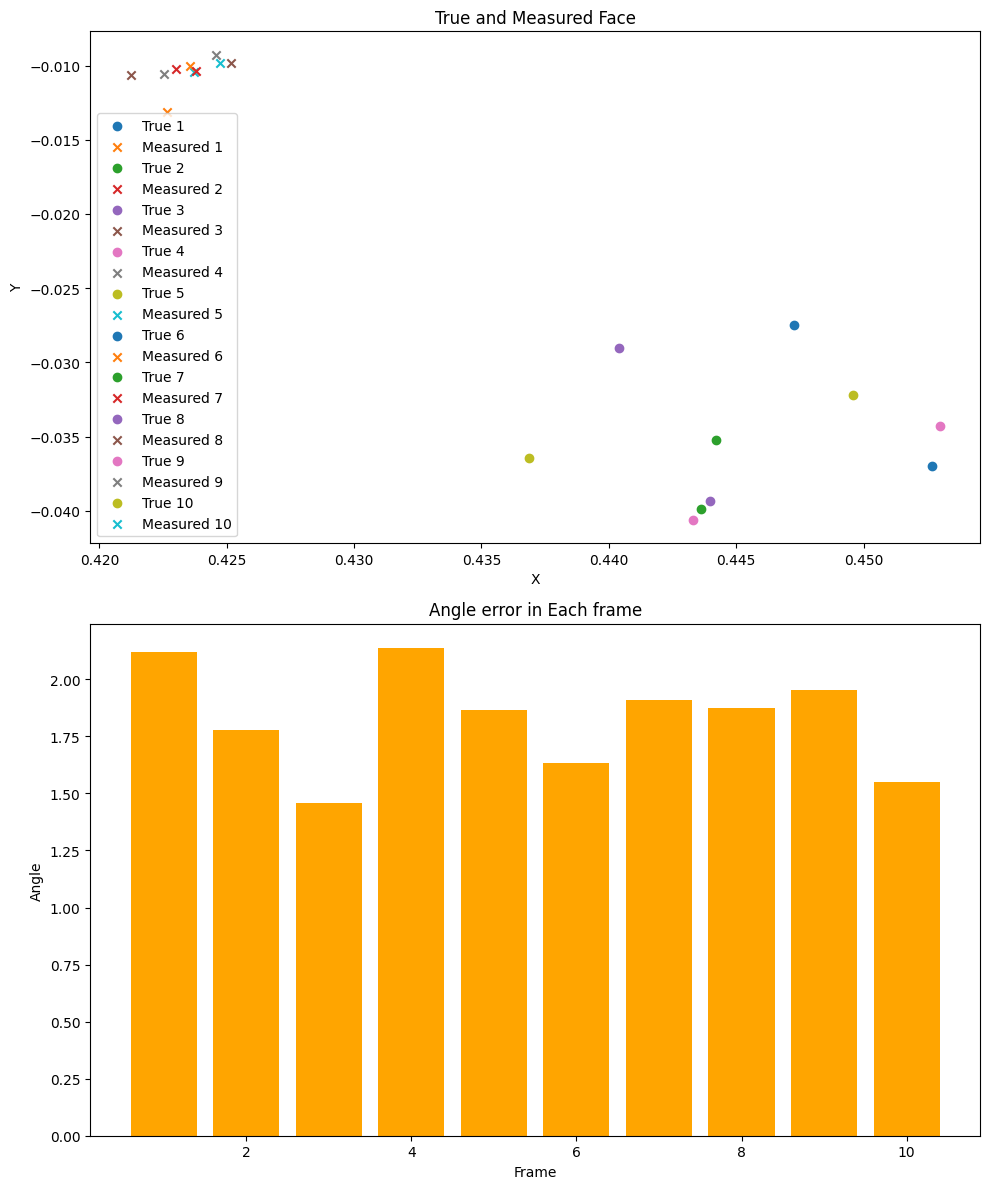

1.8277860411003188


In [8]:
import utils
pred_norm = np.array(pred_norm)
print(pred_norm)
label_norm = gazen[0:10]
print(label_norm)
# 计算角度误差
e_norm = utils.angular_error(pred_norm,label_norm)
# 可视化
plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 1)
for i in range(10):
    plt.scatter(pred_norm[i, 0], pred_norm[i, 1], marker='o', label=f'True {i+1}')
    plt.scatter(label_norm[i, 0], label_norm[i, 1], marker='x', label=f'Measured {i+1}')

plt.title('True and Measured Face')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.subplot(2, 1, 2)
plt.bar(range(1, 10+1), e_norm, color='orange')
plt.title('Angle error in Each frame')
plt.xlabel('Frame')
plt.ylabel('Angle')

plt.tight_layout()
plt.show()
print(np.mean(e_norm))

In [9]:
pred = warp_norm.vector_to_pitchyaw(np.array(pred).reshape((10,3)))
print(pred)

[[ 0.34789486  0.00178858]
 [ 0.33948997  0.00233552]
 [ 0.33536608  0.00577213]
 [ 0.34804423  0.00417747]
 [ 0.34423504  0.00362225]
 [ 0.3414615   0.0069161 ]
 [ 0.3389627  -0.00436252]
 [ 0.33918548 -0.00132479]
 [ 0.33850846 -0.0038411 ]
 [ 0.33312291 -0.00262646]]


In [10]:
eve_R = file['face_R']['data']
label = []

for i in range(10):
    label.append(np.dot(np.linalg.inv(eve_R[i]),warp_norm.pitchyaw_to_vector(label_norm)[i].T))
label = np.array(label)
label = warp_norm.vector_to_pitchyaw(label)
print(label)

[[0.32618738 0.00223308]
 [0.32628177 0.00396608]
 [0.32449956 0.00329036]
 [0.3257986  0.00279221]
 [0.32695767 0.00301953]
 [0.32662747 0.00257531]
 [0.32689407 0.00283465]
 [0.32805096 0.00279851]
 [0.32753285 0.0031112 ]
 [0.32754618 0.00315469]]


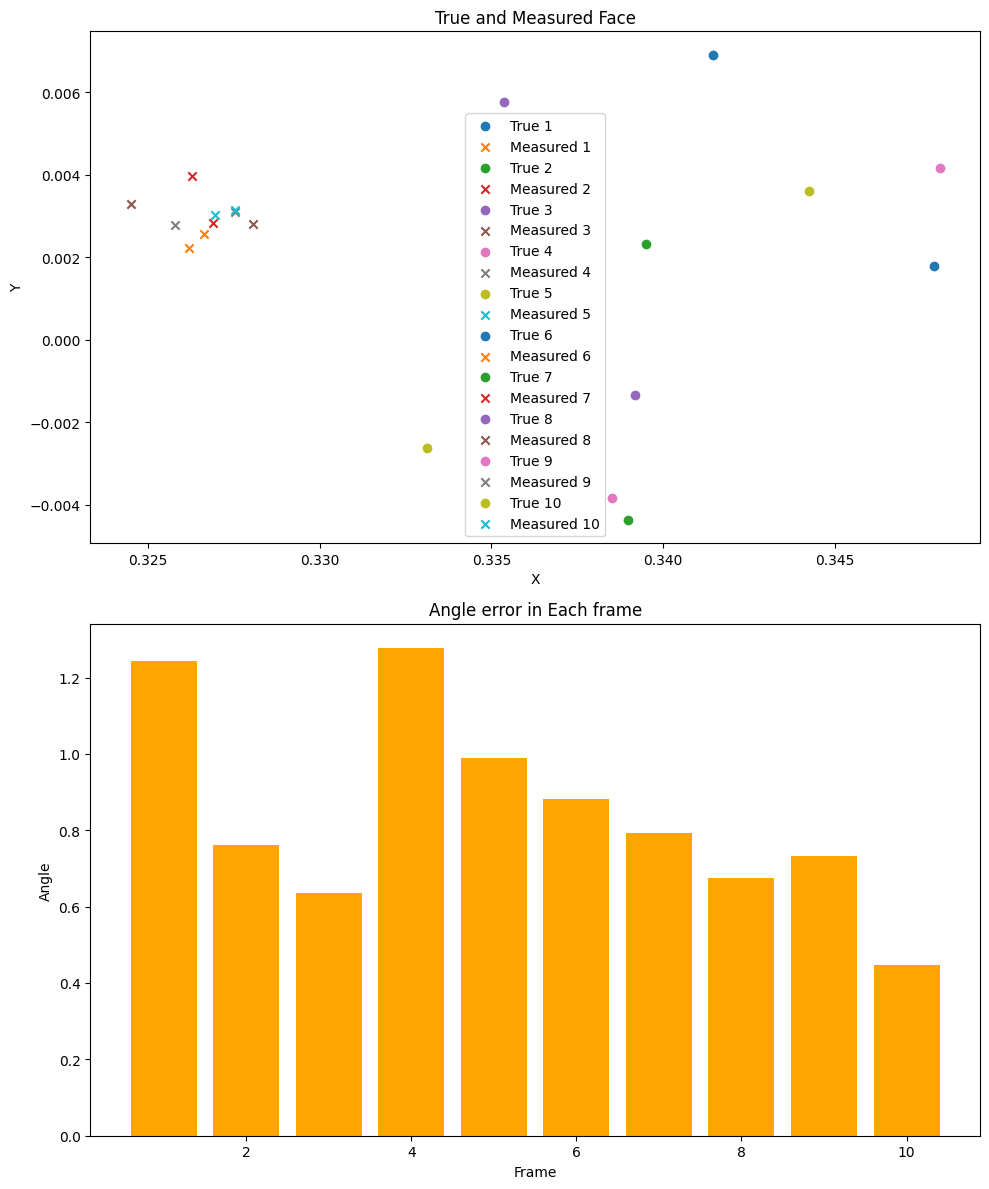

0.8441968186958757


In [11]:
import utils

# 计算角度误差
e = utils.angular_error(pred,label)
# 可视化
plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 1)
for i in range(10):
    plt.scatter(pred[i, 0], pred[i, 1], marker='o', label=f'True {i+1}')
    plt.scatter(label[i, 0], label[i, 1], marker='x', label=f'Measured {i+1}')

plt.title('True and Measured Face')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.subplot(2, 1, 2)
plt.bar(range(1, 10+1), e, color='orange')
plt.title('Angle error in Each frame')
plt.xlabel('Frame')
plt.ylabel('Angle')

plt.tight_layout()
plt.show()
print(np.mean(e))

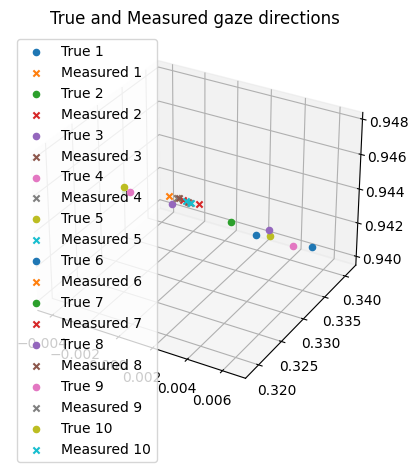

In [12]:
pred = warp_norm.pitchyaw_to_vector(pred)
label = warp_norm.pitchyaw_to_vector(label)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
for i in range(10):
    ax.scatter(pred[i, 0], pred[i, 1], pred[i, 2], marker='o', label=f'True {i+1}')
    ax.scatter(label[i, 0], label[i, 1], label[i, 2], marker='x', label=f'Measured {i+1}')

plt.title('True and Measured gaze directions')
plt.legend()
plt.show()

In [13]:
pred_gc = []
for i in range(10):
    pred_gc.append(warp_norm.vector_to_gc(pred[i], pixel_scale))
pred_gc = np.array(pred_gc)

[[  3.72594383 755.60811202]
 [  4.86531501 735.85313258]
 [ 12.02452616 726.21298629]
 [  8.70247994 755.96566501]
 [  7.54583284 746.99473825]
 [ 14.40773381 740.49230272]
 [ -9.08797608 734.62269334]
 [ -2.75977739 735.13828664]
 [ -8.00176106 733.55720273]
 [ -5.47141616 720.96583351]]
[[955.92834 554.2141 ]
 [958.5285  554.4495 ]
 [957.42255 554.9837 ]
 [956.1552  553.9321 ]
 [956.1924  553.3448 ]
 [955.66943 551.86334]
 [956.2899  554.36865]
 [955.64105 550.5817 ]
 [956.10156 551.9259 ]
 [956.0811  551.4441 ]]


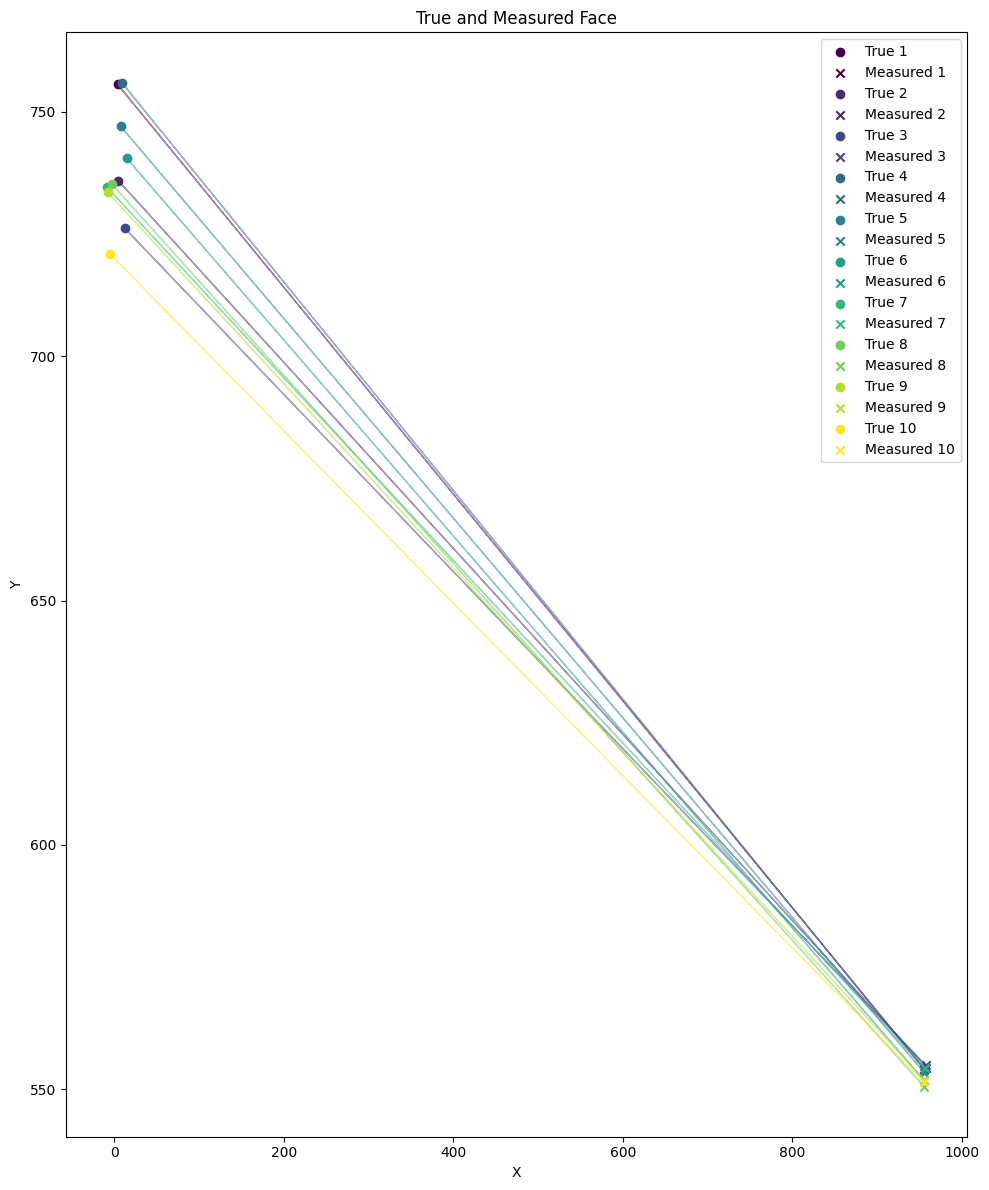

In [14]:
print(pred_gc)
print(tobii[0:10])
# 可视化
plt.figure(figsize=(10, 12))

colors = plt.cm.viridis(np.linspace(0, 1, 10))

for i in range(10):
    plt.scatter(pred_gc[i, 0], pred_gc[i, 1], marker='o',color = colors[i], label=f'True {i+1}')
    plt.scatter(tobii[i, 0], tobii[i, 1], marker='x',color = colors[i], label=f'Measured {i+1}')
    plt.arrow(tobii[i, 0], tobii[i, 1], pred_gc[i, 0] - tobii[i, 0], pred_gc[i, 1] - tobii[i, 1], color=colors[i], alpha=0.5)

plt.title('True and Measured Face')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.tight_layout()
plt.show()


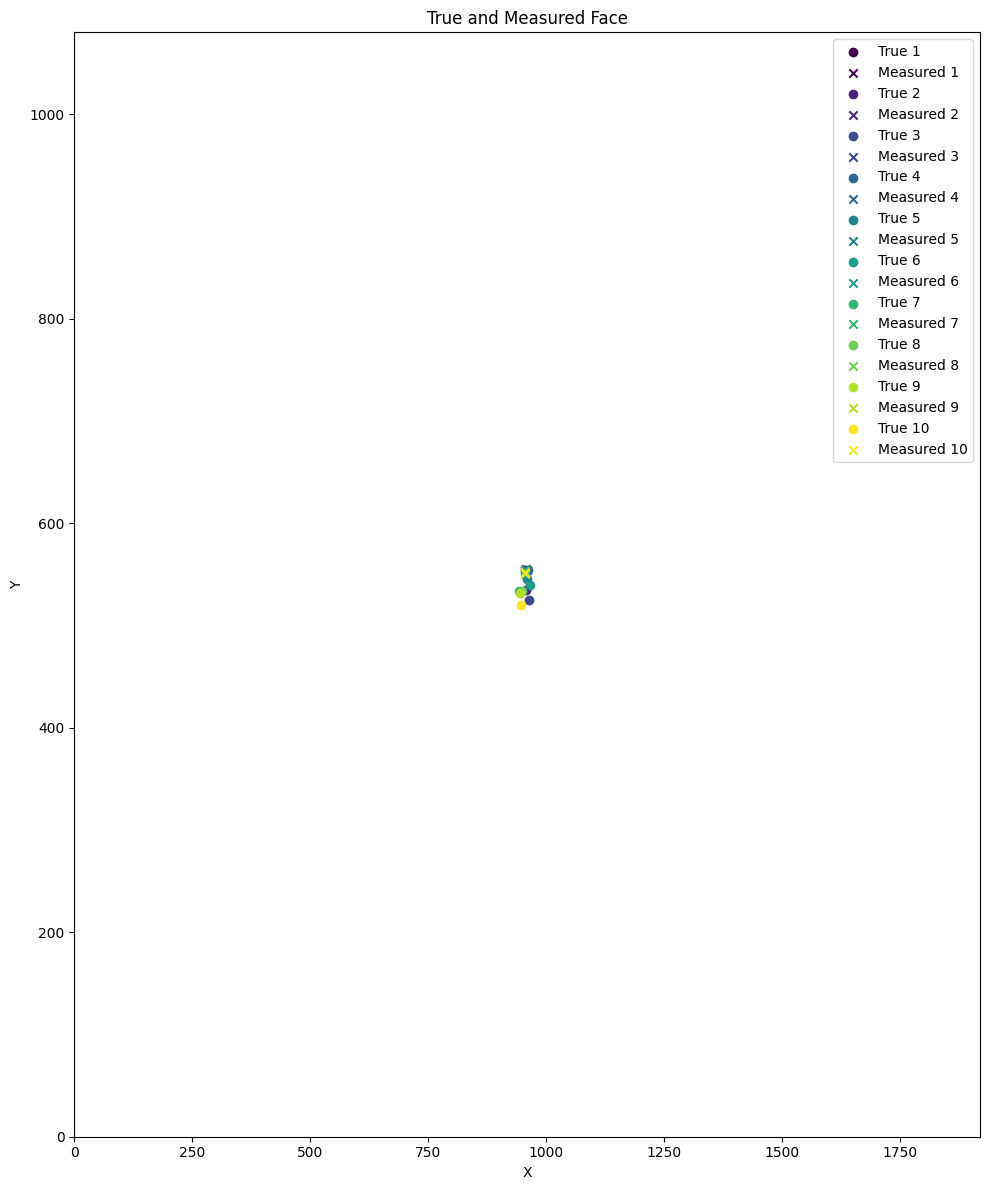

In [16]:
org = tobii[0] - pred_gc[0]
pred_gc_org = org + pred_gc
# 可视化



plt.title('True and Measured Face')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.xlim(0, 1920)
plt.ylim(0, 1080)
plt.tight_layout()
plt.show()


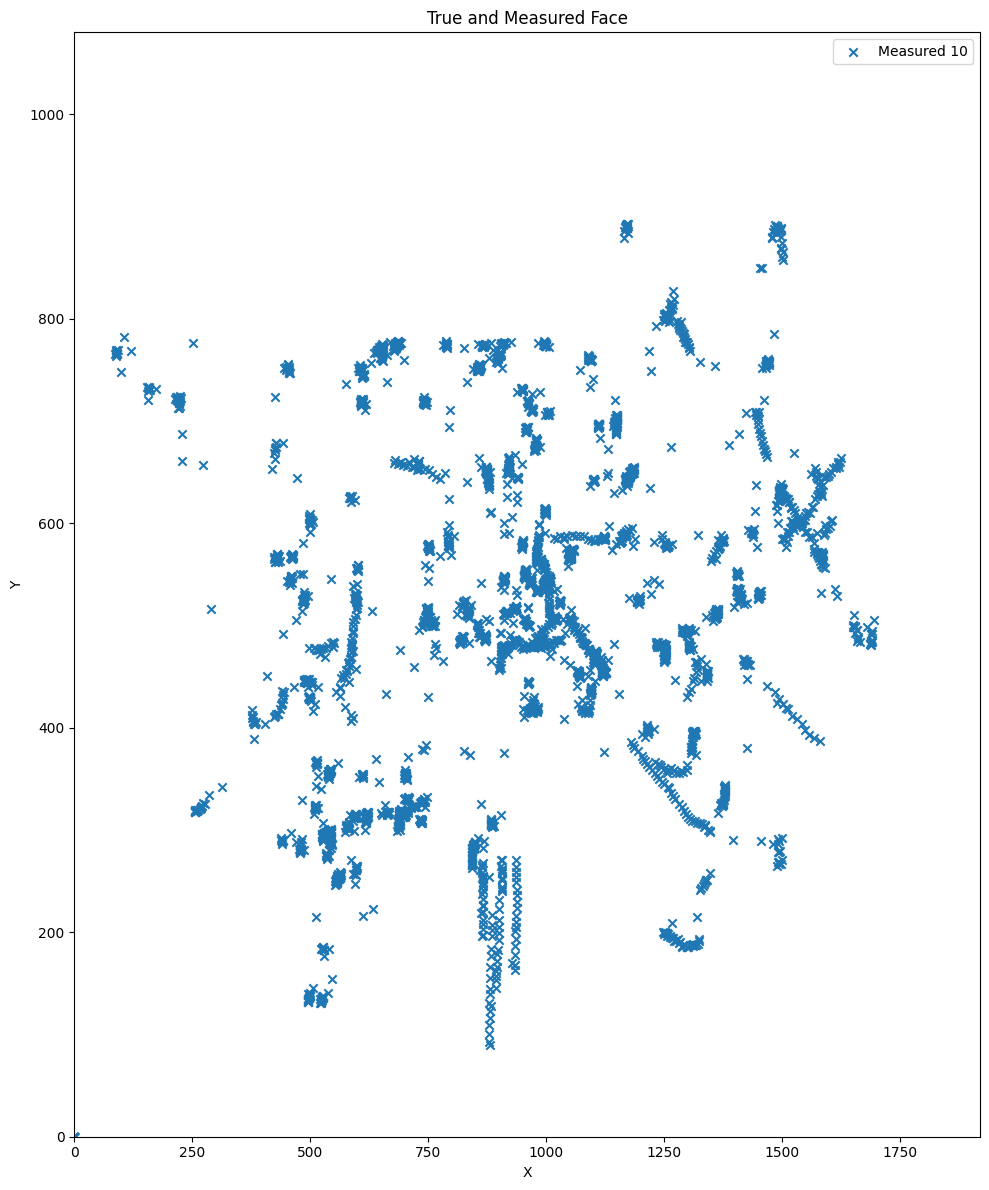

In [15]:
plt.figure(figsize=(10, 12))

colors = plt.cm.viridis(np.linspace(0, 1, 10))

plt.scatter(tobii[:, 0], tobii[:, 1], marker='x', label=f'Measured {i+1}')
plt.title('True and Measured Face')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.xlim(0, 1920)
plt.ylim(0, 1080)
plt.tight_layout()
plt.show()

# 对整个subject进行处理

## 读取已经处理好的pkl

In [3]:
import h5py
import cv2
import warp_norm
import matplotlib
import sys
sys.path.append("./FaceAlignment")
import face_alignment
from skimage import io
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from model import gaze_network
from torchvision import transforms
import utils
import pickle


with open('./eve_val01_pred_part.pkl', 'rb') as fo:
    tinydict = pickle.load(fo, encoding='bytes')

In [4]:
pred_norm = tinydict['pred_norm']
label_norm = gazen[0:500]
# print(label_norm)
e_norm = utils.angular_error(pred_norm,label_norm)
print(np.mean(e_norm))

2.2674184189269746


In [5]:
pred = tinydict['pred']
pred = warp_norm.vector_to_pitchyaw(np.array(pred).reshape((-1,3)))
eve_R = file['face_R']['data']
label = []

for i in range(pred.shape[0]):
    label.append(np.dot(np.linalg.inv(eve_R[i]),warp_norm.pitchyaw_to_vector(label_norm)[i].T))
label = np.array(label)
label = warp_norm.vector_to_pitchyaw(label)
print(label.shape)
e = utils.angular_error(pred,label)
print(np.mean(e))

(500, 2)
1.5300724076892087


## 对pog进行研究

[[ 3.72252330e+00 -7.55597526e+02]
 [ 4.88178009e+00 -7.35822589e+02]
 [ 1.20385754e+01 -7.26222866e+02]
 [ 8.70449129e+00 -7.55979105e+02]
 [ 7.53474173e+00 -7.46985270e+02]
 [ 1.44042072e+01 -7.40449790e+02]
 [-9.08498615e+00 -7.34605239e+02]
 [-2.74531093e+00 -7.35118376e+02]
 [-7.98972183e+00 -7.33567468e+02]
 [-5.49131336e+00 -7.20979002e+02]
 [-1.81120007e+01 -7.40895828e+02]
 [-5.52541408e+00 -7.27542912e+02]
 [-7.09663114e+00 -7.40313826e+02]
 [-1.73606252e+00 -7.48078378e+02]
 [-1.20954899e+00 -7.49789133e+02]
 [ 9.81425082e-01 -7.45198247e+02]
 [-3.23205609e+00 -7.30892796e+02]
 [ 9.94901022e+00 -7.28077986e+02]
 [-7.47065884e+00 -7.44223383e+02]
 [-5.36770113e+00 -7.39345295e+02]
 [ 2.05592652e+00 -7.32038289e+02]
 [-5.99264496e+00 -7.44154742e+02]
 [-1.17710638e+00 -7.29678970e+02]
 [-3.10911991e+00 -7.31363872e+02]
 [-1.33182769e+00 -7.32720246e+02]
 [ 1.61330979e+00 -7.34724580e+02]
 [ 4.30685528e-01 -7.32790228e+02]
 [-3.73423801e+00 -7.25242152e+02]
 [ 1.99397632e+00 -7

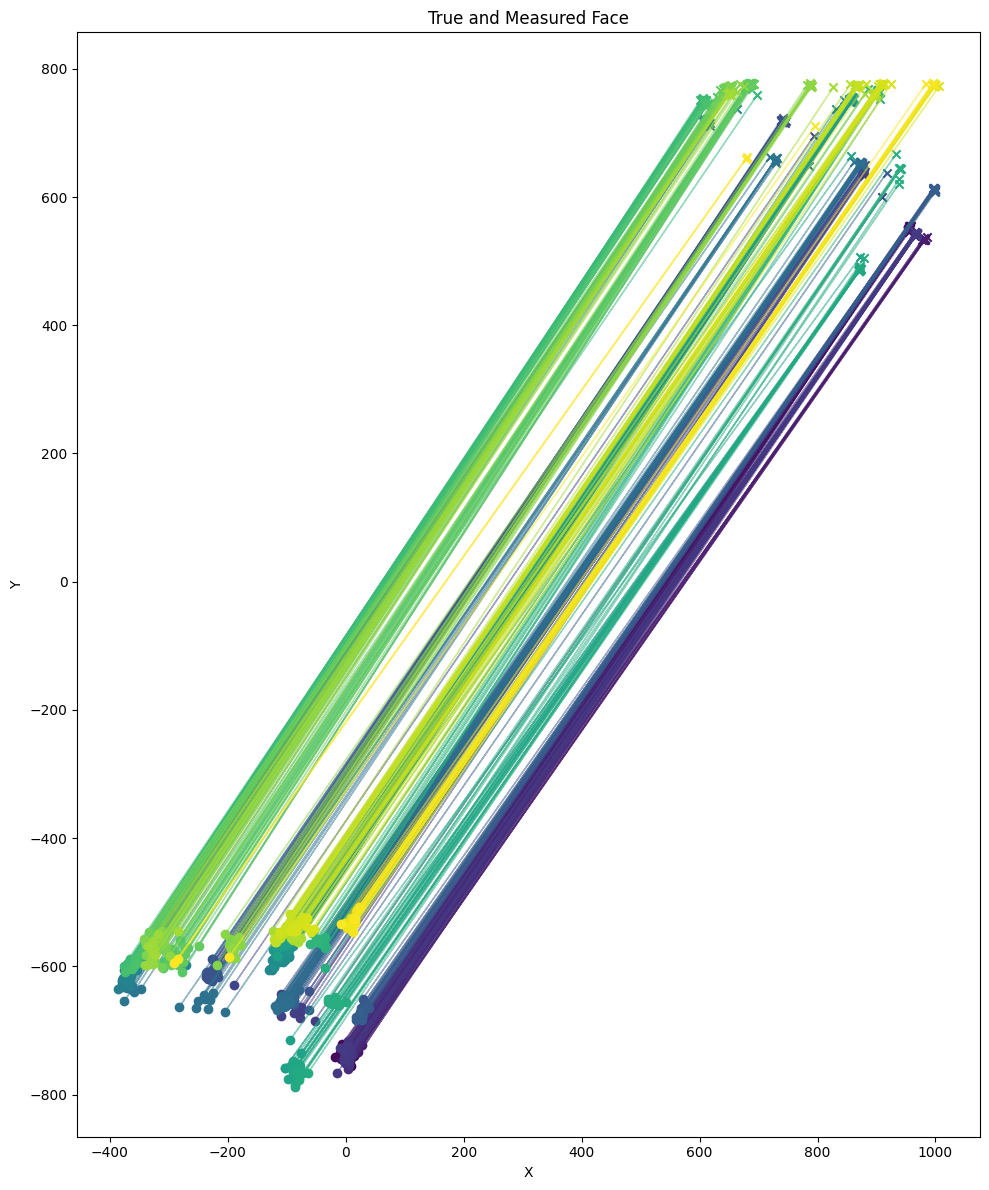

In [6]:
pred_gc = []
pred = warp_norm.pitchyaw_to_vector(pred)
for i in range(pred.shape[0]):
    ## error
    pred_gc.append(warp_norm.vector_to_gc(pred[i], pixel_scale))
pred_gc = np.array(pred_gc)
print(pred_gc)
print(tobii[0:500])
# 可视化
plt.figure(figsize=(10, 12))

colors = plt.cm.viridis(np.linspace(0, 1, 500))

for i in range(500):
    plt.scatter(pred_gc[i, 0], pred_gc[i, 1], marker='o',color = colors[i], label=f'Measured{i+1}')
    plt.scatter(tobii[i, 0], tobii[i, 1], marker='x',color = colors[i], label=f'True{i+1}')
    plt.arrow(tobii[i, 0], tobii[i, 1], pred_gc[i, 0] - tobii[i, 0], pred_gc[i, 1] - tobii[i, 1], color=colors[i], alpha=0.5)

plt.title('True and Measured Face')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend()

plt.tight_layout()
plt.show()

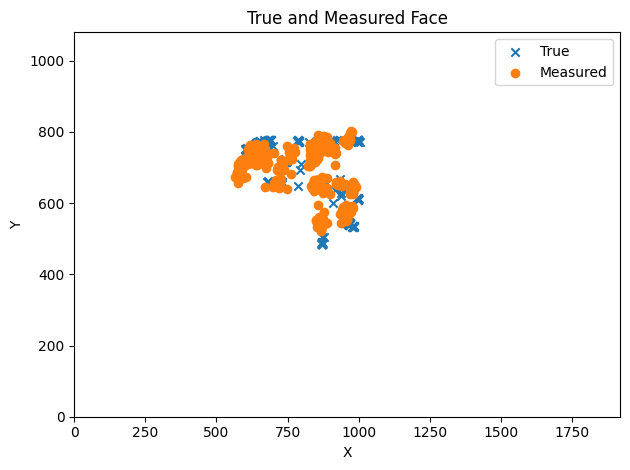

In [7]:
org = tobii[0] - pred_gc[0]
pred_gc_org = org + pred_gc


plt.scatter(tobii[0:500, 0], tobii[0:500, 1], marker='x', label=f'True')
plt.scatter(pred_gc_org[:, 0], pred_gc_org[:, 1], marker='o', label=f'Measured')
plt.title('True and Measured Face')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.xlim(0, 1920)
plt.ylim(0, 1080)
plt.tight_layout()
plt.show()
